In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating fluid cognition and neighbourhood unemployment
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_fluidcomp_uncorrected','reshist_addr1_adi_unemp','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_unemp'].median()
data.loc[data['reshist_addr1_adi_unemp'] <= val, 'reshist_addr1_adi_unemp_bin'] = 0
data.loc[data['reshist_addr1_adi_unemp'] > val, 'reshist_addr1_adi_unemp_bin'] = 1

In [4]:
data['nihtbx_fluidcomp_uncorrected_log']= np.log(data['nihtbx_fluidcomp_uncorrected']) #natural logarithm to fix skew-tailed data
col='nihtbx_fluidcomp_uncorrected_log'
data['nihtbx_fluidcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0) #standardization

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
unemp = data.reshist_addr1_adi_unemp_bin.values
target_values = data.nihtbx_fluidcomp_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
unemp_ = shared(unemp)

In [9]:
#varying intercepts and varying slopes: 
#predicting fluid cognition scores from census unemployment 

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * unemp_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 647 seconds.
The number of effective samples is smaller than 25% for some parameters.


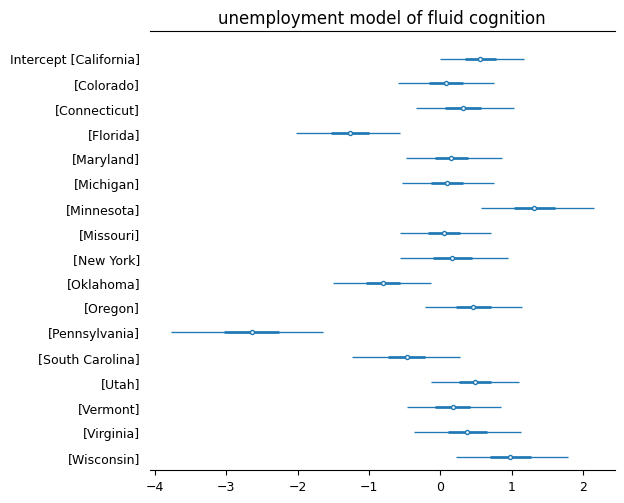

In [10]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("unemployment model of fluid cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_unemp_fluid_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_54557/3939968856.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


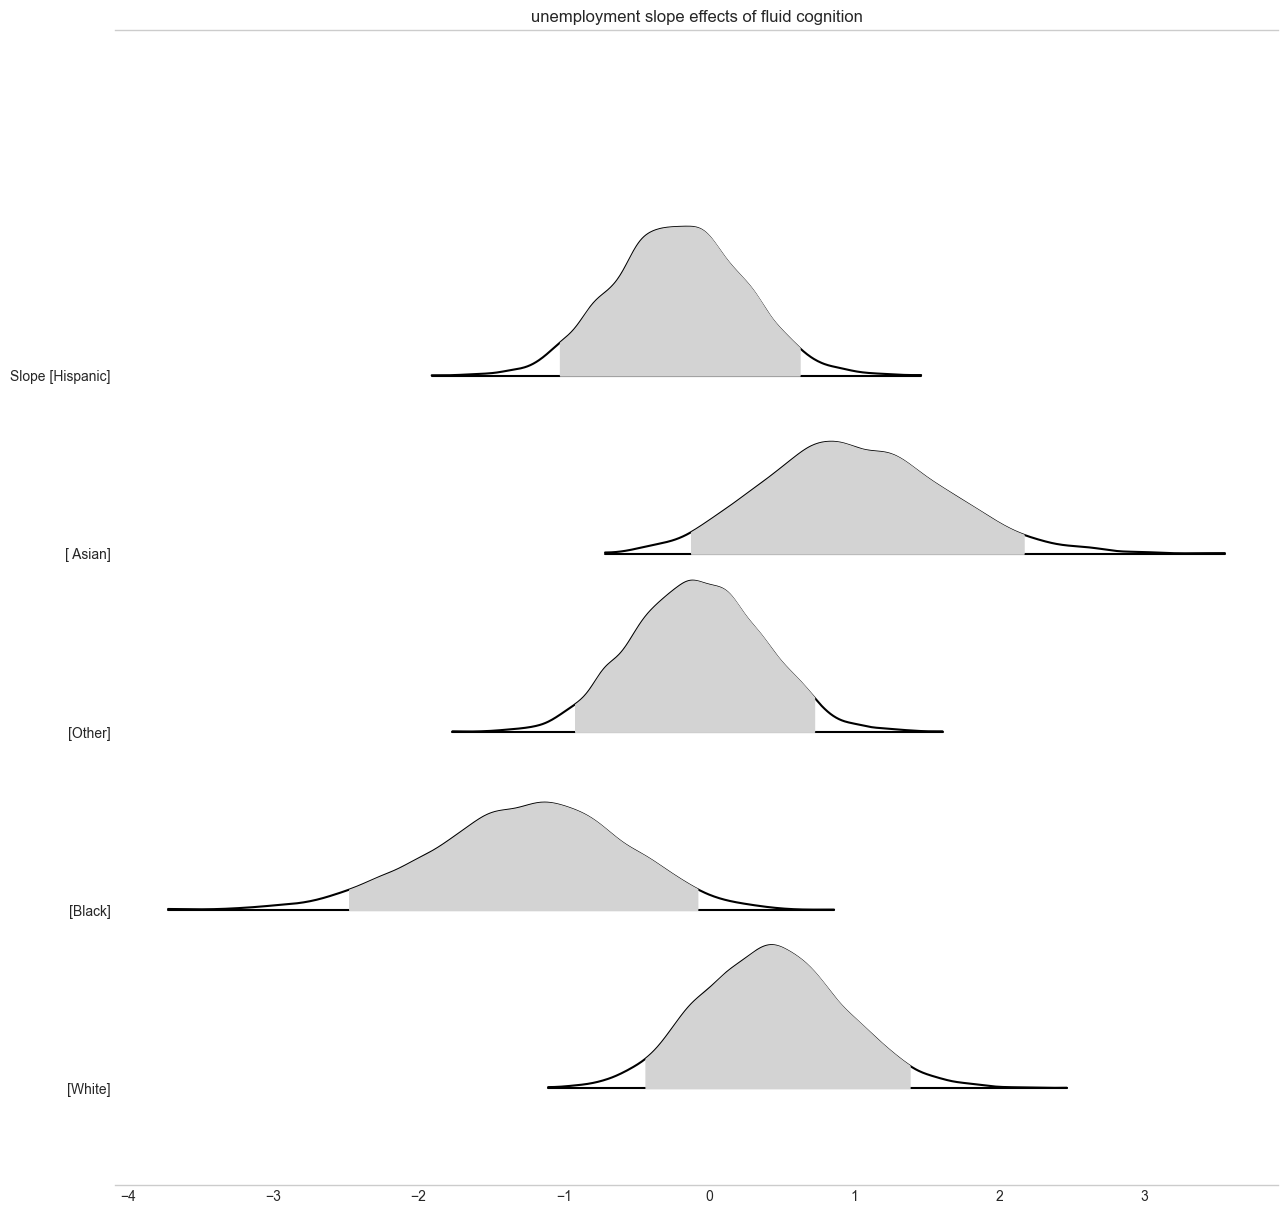

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("unemployment slope effects of fluid cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_unemp_fluid_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.358321
r2_std    0.003428
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [15]:
# get race, state and census unemployment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_unemp_df = pd.DataFrame(data['reshist_addr1_adi_unemp_bin'],columns =['reshist_addr1_adi_unemp_bin']).reset_index(drop=True)


In [16]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_unemp_df,ppc_df,left_index=True, right_index=True)


In [17]:
ppc_unemp_race_mean = (ppc_df.groupby(['reshist_addr1_adi_unemp_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_unemp_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.157529  0.321699  0.204805   
                            Black           0.222773  0.114253  0.204055   
                            Hispanic        0.138413  0.129447  0.185764   
                            Other           0.173149  0.207450  0.140466   
                            White           0.214659  0.228466  0.210628   
1.0                         Asian           0.301798  0.632254  0.147793   
                            Black          -0.646828 -0.713601 -0.746490   
                            Hispanic       -0.161287 -0.205544 -0.206399   
                            Other          -0.148787 -0.198448 -0.192656   
                            White           0.118800  0.040942  0.119333   

                                            pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.039895  0.160769  0.125186   
                            Black           0.084141  0.217643  0.072641   
                            Hispanic        0.129778  0.186166  0.136416   
                            Other           0.184344  0.186344  0.107704   
                            White           0.197435  0.249431  0.186116   
1.0                         Asian           0.457405  0.231871  0.346295   
                            Black          -0.663190 -0.716811 -0.731901   
                            Hispanic       -0.143094 -0.168481 -0.207311   
                            Other          -0.159377 -0.131808 -0.181161   
                            White           0.073744  0.127599  0.059883   

                                            pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_unemp_bin race_ethnicity                                 
0.0                         Asian           0.196714  0.184759  0.238829   
                            Black           0.243747  0.138187  0.245101   
                            Hispanic        0.174361  0.115273  0.186372   
                            Other           0.134452  0.094841  0.178246   
                            White           0.207604  0.213402  0.200026   
1.0                         Asian           0.136847  0.193651  0.697423   
                            Black          -0.715597 -0.730246 -0.749811   
                            Hispanic       -0.182906 -0.205422 -0.199610   
                            Other          -0.081786 -0.205099 -0.156866   
                            White           0.156526  0.125493  0.108738   

                                            pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_unemp_bin race_ethnicity            ...                
0.0                         Asian           0.149643  ...     0.102210   
                            Black           0.127357  ...     0.085293   
                            Hispanic        0.217519  ...     0.167712   
                            Other           0.133699  ...     0.158456   
                            White           0.203348  ...     0.186535   
1.0                         Asian           0.341657  ...     0.266235   
                            Black          -0.675059  ...    -0.713009   
                            Hispanic       -0.196895  ...    -0.202933   
                            Other          -0.173546  ...    -0.170827   
                            White           0.094284  ...     0.082173   

                                            pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_unemp_bin race_ethnicity                             
0.0                         Asian              0.155121     0.213437   
                            Black              0.207385     0.072699   
                            Hispanic           0.224231     0.178163   
                            Other              0.194269 

In [18]:
ppc_unemp_race_mean_summ=ppc_unemp_race_mean.mean(axis=1)
ppc_unemp_race_mean_summ

reshist_addr1_adi_unemp_bin  race_ethnicity
0.0                          Asian             0.214128
                             Black             0.156422
                             Hispanic          0.159597
                             Other             0.175110
                             White             0.202622
1.0                          Asian             0.406345
                             Black            -0.722569
                             Hispanic         -0.190247
                             Other            -0.155552
                             White             0.096706
dtype: float64

In [19]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.209271,0.433079,0.184358,0.189635,0.186270,0.204487,0.175243,0.187948,0.403303,0.218509,...,0.161037,0.256877,0.226256,0.234058,0.309923,0.481394,0.371334,0.234429,0.317266,0.143888
Black,-0.486803,-0.561258,-0.571570,-0.525665,-0.544852,-0.583849,-0.539057,-0.570436,-0.566726,-0.527398,...,-0.566104,-0.601588,-0.592414,-0.516823,-0.590713,-0.599367,-0.537149,-0.622150,-0.550450,-0.611627
Hispanic,-0.068618,-0.101962,-0.085139,-0.058720,-0.058822,-0.101028,-0.072437,-0.106261,-0.080262,-0.068755,...,-0.088326,-0.039577,-0.082743,-0.110531,-0.012000,-0.089291,-0.080313,-0.043825,-0.066615,-0.061003
Other,0.014316,0.007192,-0.023886,0.014762,0.029377,-0.034813,0.027767,-0.053140,0.012912,-0.017886,...,-0.004002,0.022745,0.006471,0.016137,0.074849,-0.043535,0.004365,-0.019070,0.000325,0.031412
White,0.181004,0.162629,0.178576,0.154009,0.206658,0.141797,0.189671,0.182539,0.167976,0.165057,...,0.149895,0.169960,0.161883,0.174674,0.163880,0.142428,0.165869,0.160482,0.160761,0.148554


In [20]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [21]:
ppc_unemp_state_mean = (ppc_df.groupby(['reshist_addr1_adi_unemp_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_unemp_state_mean_summ = ppc_unemp_state_mean.mean(axis=1)


In [22]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [23]:
ppc_unemp_state_mean_summ_list=ppc_unemp_state_mean_summ.to_numpy()
low_unemp_state = ppc_unemp_state_mean_summ_list[:17]
high_unemp_state = ppc_unemp_state_mean_summ_list[-17:]

In [24]:
mean_predictions_state = [low_unemp_state,high_unemp_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.250698,0.176142,0.213984,-0.029398,0.188293,0.178741,0.366623,0.171495,0.189085,0.040992,0.234858,-0.242826,0.091179,0.238146,0.190252,0.222103,0.314781
1,-0.042409,-0.067855,-0.123958,-0.397368,-0.385857,-0.155061,0.203685,-0.275236,-0.278850,-0.313409,0.067445,-0.789527,-0.292277,0.080693,0.079588,-0.221906,0.036827


In [25]:
ppc_unemp_race_mean_summ_list=ppc_unemp_race_mean_summ.to_numpy()
low_unemp_race = ppc_unemp_race_mean_summ_list[:5]
high_unemp_race = ppc_unemp_race_mean_summ_list[-5:]

In [26]:
# initialize list of lists 
mean_predictions_race = [low_unemp_race,high_unemp_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.214128,0.156422,0.159597,0.175110,0.202622
1,0.406345,-0.722569,-0.190247,-0.155552,0.096706


In [27]:
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','Nonemployed_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [28]:
val = census_data['Nonemployed_score'].median()
census_data.loc[census_data['Nonemployed_score'] < val, 'Nonemployed_score_bin'] = 0
census_data.loc[census_data['Nonemployed_score'] >= val, 'Nonemployed_score_bin'] = 1

In [29]:
census = (census_data.groupby(['state','race_ethnicity','Nonemployed_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,Nonemployed_score_bin,freq
0,california,Asian,0.0,767423
1,california,Asian,1.0,1067892
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,5651418
...,...,...,...,...
138,wisconsin,Black,1.0,33831
139,wisconsin,Hispanic,0.0,88054
140,wisconsin,Other,0.0,183517
141,wisconsin,White,0.0,4177330


In [30]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,Nonemployed_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,767423,1,0
1,california,Asian,1.0,1067892,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,5651418,0,0


In [31]:
#fix theano shared tensor type error
census=census.astype({'Nonemployed_score_bin':'uint8'})

In [32]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_unemp = census.Nonemployed_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
unemp_.set_value(ps_unemp)

In [33]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [34]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(143, 8000)

In [35]:
censust=census
censust

,state,race_ethnicity,Nonemployed_score_bin,freq,race_enc,state_enc
0,california,Asian,0,767423,1,0
1,california,Asian,1,1067892,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,5651418,0,0
...,...,...,...,...,...,...
138,wisconsin,Black,1,33831,3,16
139,wisconsin,Hispanic,0,88054,0,16
140,wisconsin,Other,0,183517,2,16
141,wisconsin,White,0,4177330,4,16


In [36]:
# get race, state, and census unemployment columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_unemp_df2 = pd.DataFrame(censust['Nonemployed_score_bin'],columns =['Nonemployed_score_bin']).reset_index(drop=True)


In [37]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_unemp_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,Nonemployed_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-1.577811,0.022112,-0.338595,-0.746127,-0.948111,0.660969,...,0.749058,-0.138920,-1.587312,-1.883002,0.303144,-0.353655,-1.122372,2.170742,0.530359,-1.290188
1,california,Asian,1,1067892,0.619364,1.657645,0.628972,2.061426,-0.248677,1.232103,...,0.829300,0.395134,-1.172344,-0.977133,0.578145,-0.668102,0.626041,0.662329,0.151170,-0.055086
2,california,Black,0,3168044,1.180988,2.039235,1.429928,0.349340,-0.194198,0.104901,...,-0.095172,-0.717932,-0.817626,2.332346,0.476308,0.466105,1.117275,0.063313,-0.079202,-0.268988
3,california,Black,1,786431,0.167237,-0.346147,-1.383568,-0.254446,-1.831242,-1.358324,...,-0.776577,-0.678470,-1.374489,-0.981418,-0.032501,-0.282659,-0.485687,-0.098464,0.242714,-1.534322
4,california,Hispanic,0,5651418,-1.165067,-1.458297,0.216263,0.299720,-0.561694,-1.136412,...,0.119874,0.528493,-0.169318,-0.882303,0.409121,0.334641,1.481916,0.834126,1.320245,0.645947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,wisconsin,Black,1,33831,0.934122,-0.305755,-1.552759,-0.019807,-0.158491,-1.358553,...,-0.243882,-0.844870,-0.067046,-0.789755,0.670712,1.069236,-0.443836,-0.668504,-2.319949,-0.629502
139,wisconsin,Hispanic,0,88054,0.312506,0.869772,-1.304506,0.728895,0.662324,-0.246858,...,0.022264,0.627485,-0.003992,-1.904164,1.325250,0.197130,2.485731,1.649983,-1.127419,0.560814
140,wisconsin,Other,0,183517,-0.274813,0.709245,0.790097,-0.412775,-0.859802,0.371721,...,-0.804999,-0.153954,0.933595,1.514255,-0.087857,-0.301247,0.363743,-0.624390,-1.336900,1.264852
141,wisconsin,White,0,4177330,0.160265,0.422621,0.786767,0.468252,1.364424,1.448923,...,-0.324232,0.085233,-0.355542,1.340018,0.570795,2.823509,0.655422,0.996945,-0.396583,2.281062


In [38]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','Nonemployed_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -1.210848e+06   
                          1                     1    6.614137e+05   
           Black          0                     2    3.741424e+06   
                          1                     3    1.315203e+05   
           Hispanic       0                     4   -6.584280e+06   
...                                                           ...   
wisconsin  Black          1                     138  3.160229e+04   
           Hispanic       0                     139  2.751743e+04   
           Other          0                     140 -5.043277e+04   
           White          0                     141  6.694808e+05   
                          1                     142 -2.641300e+04   

                                                         pp_cog_1  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0    1.696941e+04   
                          1                     1    1.770186e+06   
           Black          0                     2    6.460387e+06   
                          1                     3   -2.722211e+05   
           Hispanic       0                     4   -8.241446e+06   
...                                                           ...   
wisconsin  Black          1                     138 -1.034401e+04   
           Hispanic       0                     139  7.658686e+04   
           Other          0                     140  1.301586e+05   
           White          0                     141  1.765428e+06   
                          1                     142  1.981653e+04   

                                                         pp_cog_2  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -2.598457e+05   
                          1                     1    6.716747e+05   
           Black          0                     2    4.530074e+06   
                          1                     3   -1.088081e+06   
           Hispanic       0                     4    1.222192e+06   
...                                                           ...   
wisconsin  Black          1                     138 -5.253138e+04   
           Hispanic       0                     139 -1.148670e+05   
           Other          0                     140  1.449963e+05   
           White          0                     141  3.286586e+06   
                          1                     142  1.562574e+04   

                                                         pp_cog_3  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -5.725952e+05   
                          1                     1    2.201380e+06   
           Black          0                     2    1.106724e+06   
                          1                     3   -2.001042e+05   
           Hispanic       0                     4    1.693844e+06   
...                                                           ...   
wisconsin  Black          1                     138 -6.700942e+02   
           Hispanic       0                     139  6.418209e+04   
           Other          0                     140 -7.575121e+04   
           White          0                     141  1.956044e+06   
                          1                     142  5.508045e+04   

                                                         pp_cog_4  \
state      race_ethnicity Nonemployed_score_bin                     
california Asian          0                     0   -7.276023e+05   
                          1                     1   -2.655602e+05   
           Black          0                     2   -6.152267e+05   
                          1                     3   -1.440145e+06   
           Hispanic       0                     4  

In [39]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-1.210848e+06,1.696941e+04,-2.598457e+05,-5.725952e+05,-7.276023e+05,5.072428e+05,-3.276315e+05,9.577788e+05,2.840567e+05,-7.676860e+05,...,5.748441e+05,-1.066102e+05,-1.218140e+06,-1.445059e+06,2.326393e+05,-2.714030e+05,-8.613338e+05,1.665877e+06,4.070097e+05,-9.901200e+05
1,6.614137e+05,1.770186e+06,6.716747e+05,2.201380e+06,-2.655602e+05,1.315753e+06,1.272480e+06,-1.320763e+06,1.609531e+05,-3.877599e+04,...,8.856027e+05,4.219600e+05,-1.251936e+06,-1.043472e+06,6.173964e+05,-7.134606e+05,6.685440e+05,7.072954e+05,1.614336e+05,-5.882582e+04
2,3.741424e+06,6.460387e+06,4.530074e+06,1.106724e+06,-6.152267e+05,3.323303e+05,7.687711e+05,4.489426e+05,1.081756e+06,-1.322158e+06,...,-3.015088e+05,-2.274440e+06,-2.590276e+06,7.388976e+06,1.508965e+06,1.476643e+06,3.539577e+06,2.005779e+05,-2.509165e+05,-8.521672e+05
3,1.315203e+05,-2.722211e+05,-1.088081e+06,-2.001042e+05,-1.440145e+06,-1.068228e+06,-5.964115e+05,-2.315505e+05,-1.959438e+06,-1.484721e+06,...,-6.107244e+05,-5.335701e+05,-1.080941e+06,-7.718177e+05,-2.555988e+04,-2.222921e+05,-3.819593e+05,-7.743541e+04,1.908779e+05,-1.206639e+06
4,-6.584280e+06,-8.241446e+06,1.222192e+06,1.693844e+06,-3.174369e+06,-6.422340e+06,1.422610e+07,-2.325096e+06,3.488787e+06,-6.615053e+06,...,6.774563e+05,2.986734e+06,-9.568892e+05,-4.986265e+06,2.312114e+06,1.891198e+06,8.374926e+06,4.713993e+06,7.461254e+06,3.650515e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,3.160229e+04,-1.034401e+04,-5.253138e+04,-6.700942e+02,-5.361918e+03,-4.596121e+04,-1.916722e+04,-2.719989e+04,-6.541902e+04,1.214945e+04,...,-8.250763e+03,-2.858280e+04,-2.268243e+03,-2.671819e+04,2.269085e+04,3.617332e+04,-1.501542e+04,-2.261618e+04,-7.848621e+04,-2.129668e+04
139,2.751743e+04,7.658686e+04,-1.148670e+05,6.418209e+04,5.832024e+04,-2.173680e+04,1.869780e+04,4.097530e+04,-8.437816e+04,4.608216e+04,...,1.960408e+03,5.525257e+04,-3.515051e+02,-1.676693e+05,1.166936e+05,1.735809e+04,2.188786e+05,1.452876e+05,-9.927377e+04,4.938192e+04
140,-5.043277e+04,1.301586e+05,1.449963e+05,-7.575121e+04,-1.577883e+05,6.821705e+04,-7.353120e+04,1.900315e+05,2.103202e+05,2.365713e+05,...,-1.477311e+05,-2.825314e+04,1.713306e+05,2.778916e+05,-1.612319e+04,-5.528400e+04,6.675295e+04,-1.145862e+05,-2.453440e+05,2.321218e+05
141,6.694808e+05,1.765428e+06,3.286586e+06,1.956044e+06,5.699649e+06,6.052630e+06,4.367406e+06,3.247062e+06,4.000115e+06,-4.675052e+05,...,-1.354423e+06,3.560444e+05,-1.485215e+06,5.597697e+06,2.384399e+06,1.179473e+07,2.737914e+06,4.164570e+06,-1.656657e+06,9.528748e+06


In [40]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,Nonemployed_score_bin,freq
0,california,Asian,0,767423
1,california,Asian,1,1067892
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,5651418
...,...,...,...,...
138,wisconsin,Black,1,33831
139,wisconsin,Hispanic,0,88054
140,wisconsin,Other,0,183517
141,wisconsin,White,0,4177330


In [41]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,Nonemployed_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-1.210848e+06,1.696941e+04,-2.598457e+05,-5.725952e+05,-7.276023e+05,5.072428e+05,...,5.748441e+05,-1.066102e+05,-1.218140e+06,-1.445059e+06,2.326393e+05,-2.714030e+05,-8.613338e+05,1.665877e+06,4.070097e+05,-9.901200e+05
1,california,Asian,1,1067892,6.614137e+05,1.770186e+06,6.716747e+05,2.201380e+06,-2.655602e+05,1.315753e+06,...,8.856027e+05,4.219600e+05,-1.251936e+06,-1.043472e+06,6.173964e+05,-7.134606e+05,6.685440e+05,7.072954e+05,1.614336e+05,-5.882582e+04
2,california,Black,0,3168044,3.741424e+06,6.460387e+06,4.530074e+06,1.106724e+06,-6.152267e+05,3.323303e+05,...,-3.015088e+05,-2.274440e+06,-2.590276e+06,7.388976e+06,1.508965e+06,1.476643e+06,3.539577e+06,2.005779e+05,-2.509165e+05,-8.521672e+05
3,california,Black,1,786431,1.315203e+05,-2.722211e+05,-1.088081e+06,-2.001042e+05,-1.440145e+06,-1.068228e+06,...,-6.107244e+05,-5.335701e+05,-1.080941e+06,-7.718177e+05,-2.555988e+04,-2.222921e+05,-3.819593e+05,-7.743541e+04,1.908779e+05,-1.206639e+06
4,california,Hispanic,0,5651418,-6.584280e+06,-8.241446e+06,1.222192e+06,1.693844e+06,-3.174369e+06,-6.422340e+06,...,6.774563e+05,2.986734e+06,-9.568892e+05,-4.986265e+06,2.312114e+06,1.891198e+06,8.374926e+06,4.713993e+06,7.461254e+06,3.650515e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,wisconsin,Black,1,33831,3.160229e+04,-1.034401e+04,-5.253138e+04,-6.700942e+02,-5.361918e+03,-4.596121e+04,...,-8.250763e+03,-2.858280e+04,-2.268243e+03,-2.671819e+04,2.269085e+04,3.617332e+04,-1.501542e+04,-2.261618e+04,-7.848621e+04,-2.129668e+04
139,wisconsin,Hispanic,0,88054,2.751743e+04,7.658686e+04,-1.148670e+05,6.418209e+04,5.832024e+04,-2.173680e+04,...,1.960408e+03,5.525257e+04,-3.515051e+02,-1.676693e+05,1.166936e+05,1.735809e+04,2.188786e+05,1.452876e+05,-9.927377e+04,4.938192e+04
140,wisconsin,Other,0,183517,-5.043277e+04,1.301586e+05,1.449963e+05,-7.575121e+04,-1.577883e+05,6.821705e+04,...,-1.477311e+05,-2.825314e+04,1.713306e+05,2.778916e+05,-1.612319e+04,-5.528400e+04,6.675295e+04,-1.145862e+05,-2.453440e+05,2.321218e+05
141,wisconsin,White,0,4177330,6.694808e+05,1.765428e+06,3.286586e+06,1.956044e+06,5.699649e+06,6.052630e+06,...,-1.354423e+06,3.560444e+05,-1.485215e+06,5.597697e+06,2.384399e+06,1.179473e+07,2.737914e+06,4.164570e+06,-1.656657e+06,9.528748e+06


In [42]:
#final step of poststratification - by race & unemp 
#data-weighted average
ppc_unemp_race_poststrat = ppc_poststrat_df.groupby(['Nonemployed_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_unemp_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  pp_cog_3  \
Nonemployed_score_bin race_ethnicity                                           
0                     Asian           0.049384 -0.172605  0.299500 -0.184155   
                      Black           0.329508  0.416778  0.472234  0.501078   
                      Hispanic       -0.489156  0.341506  0.292266  0.386347   
                      Other           0.056910 -0.313480  0.279830  0.023324   
                      White           0.246784  1.021408 -0.304994  0.143758   
1                     Asian           0.605947  1.347219  0.607943  0.766228   
                      Black          -0.377762 -0.786998 -0.313901 -1.002567   
                      Hispanic       -0.845686  0.103508  0.411267 -0.293242   
                      Other          -0.388502  0.018320 -0.903329 -0.096950   
                      White           0.221084 -0.165339 -0.478020 -0.172282   

                                      pp_cog_4  pp_cog_5  pp_cog_6  pp_cog_7  \
Nonemployed_score_bin race_ethnicity                                           
0                     Asian           0.499505 -0.763638 -0.886642 -0.324546   
                      Black           0.460017 -0.003149  0.552059  0.494005   
                      Hispanic       -0.006449  0.328644  0.645895  0.209452   
                      Other          -0.311682  0.517235 -0.618163 -0.115722   
                      White           0.432089  0.104504  0.310099  0.329336   
1                     Asian           0.127596  0.265776  0.367912  0.349787   
                      Black          -0.814660 -1.332585 -1.228664 -0.658935   
                      Hispanic        0.046837 -0.396383 -1.008273  0.233555   
                      Other          -0.452939  0.176043 -0.588038 -0.985113   
                      White          -0.143860  0.597429  0.325347  0.479129   

                                      pp_cog_8  pp_cog_9  ...  pp_cog_7990  \
Nonemployed_score_bin race_ethnicity                      ...                
0                     Asian           0.777661 -0.192216  ...     0.051561   
                      Black          -0.397140 -0.224730  ...     0.156067   
                      Hispanic        0.381380 -0.359620  ...     1.172703   
                      Other           0.320652  0.725135  ...    -0.216864   
                      White           0.296297  0.551284  ...    -0.036637   
1                     Asian           0.803513 -0.521517  ...     0.277986   
                      Black          -0.892217 -1.048148  ...    -1.129639   
                      Hispanic        0.270396 -0.843375  ...    -0.518984   
                      Other          -0.032002  0.403703  ...    -0.281653   
                      White           0.517458 -0.285311  ...     0.240400   

                                      pp_cog_7991  pp_cog_7992  pp_cog_7993  \
Nonemployed_score_bin race_ethnicity                                          
0                     Asian             -0.389121     0.080473    -0.582059   
                      Black              0.121339    -0.485140     0.666745   
                      Hispanic           0.313666     0.016632    -0.043113   
                      Other              0.077357    -0.267175     0.298691   
                      White              0.731912     0.360403    -0.418625   
1                     Asian              0.320923    -0.100335    -0.325009   
                      Black             -1.043093    -1.077546    -0.544027   
                      Hispanic           0.496194    -0.488324    -0.146042   
                      Other             -0.477565    -0.612025     0.619809   
                      White              0.261090    -0.436313    -0.285095   

                                      pp_cog_7994  pp_cog_7995  pp_cog_7996  \
Nonemployed_score_bin race_ethnicity                                          
0                     Asian              0.531868    -0.007503     0.595

In [43]:
#summarize race & unemp poststrat results
ppc_unemp_race_poststrat_summ = ppc_unemp_race_poststrat.mean(axis=1)
ppc_unemp_race_poststrat_summ

Nonemployed_score_bin  race_ethnicity
0                      Asian             0.147722
                       Black             0.158479
                       Hispanic          0.146115
                       Other             0.151321
                       White             0.173648
1                      Asian             0.268547
                       Black            -0.680291
                       Hispanic         -0.187441
                       Other            -0.195086
                       White             0.047461
dtype: float64

In [44]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.178097
Black      -0.021091
Hispanic    0.050885
Other      -0.089436
White       0.132906
dtype: float64

In [45]:
#for the lollipops
#final step poststrat - by state & unemp
ppc_unemp_state_poststrat = ppc_poststrat_df.groupby(['Nonemployed_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_unemp_state_poststrat_summ = ppc_unemp_state_poststrat.mean(axis=1)
ppc_unemp_state_poststrat_summ

Nonemployed_score_bin  state        
0                      california       0.249527
                       colorado         0.187100
                       connecticut      0.211800
                       florida         -0.027136
                       maryland         0.188808
                       michigan         0.180654
                       minnesota        0.373640
                       missouri         0.186995
                       newyork          0.199945
                       oklahoma         0.047971
                       oregon           0.232397
                       pennsylvania    -0.229558
                       southcarolina    0.086422
                       utah             0.237424
                       vermont          0.197106
                       virginia         0.217674
                       wisconsin        0.323036
1                      california       0.031037
                       colorado        -0.029195
                       florida  

In [46]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.174968
colorado         0.169001
connecticut      0.211800
florida         -0.124926
maryland         0.070787
michigan         0.105474
minnesota        0.372548
missouri         0.128856
newyork          0.124935
oklahoma        -0.013828
oregon           0.171693
pennsylvania    -0.268560
southcarolina   -0.041156
utah             0.229676
vermont          0.196184
virginia         0.174958
wisconsin        0.316857
dtype: float64

In [47]:
ppc_unemp_state_poststrat_summ_list=ppc_unemp_state_poststrat_summ.tolist()

In [48]:
#fill in missing value for connecticut
ppc_unemp_state_poststrat_summ_list.insert(19,ppc_unemp_state_mean_summ.iloc[19])

In [50]:
low_unemp_state_poststrat = ppc_unemp_state_poststrat_summ_list[:17]
high_unemp_state_poststrat = ppc_unemp_state_poststrat_summ_list[-17:]

In [51]:
ppc_unemp_race_poststrat_summ_list=ppc_unemp_race_poststrat_summ.tolist()

In [52]:
low_unemp_race_poststrat = ppc_unemp_race_poststrat_summ_list[:5]
high_unemp_race_poststrat = ppc_unemp_race_poststrat_summ_list[-5:]

In [53]:
mean_predictions_state_ps = [low_unemp_state_poststrat,high_unemp_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.249527,0.187100,0.211800,-0.027136,0.188808,0.180654,0.373640,0.186995,0.199945,0.047971,0.232397,-0.229558,0.086422,0.237424,0.197106,0.217674,0.323036
1,0.031037,-0.029195,-0.123958,-0.254629,-0.552027,0.027415,0.253378,-0.044399,-0.009308,-0.095097,0.112023,-0.355962,-0.162456,0.113034,0.104289,0.039423,-0.004765


In [54]:
# initialize list of lists 
mean_predictions_race_ps = [low_unemp_race_poststrat,high_unemp_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.147722,0.158479,0.146115,0.151321,0.173648
1,0.268547,-0.680291,-0.187441,-0.195086,0.047461


In [55]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([0.055904330252778606,
  0.10302845584301595,
  0.017805669992638426,
  -0.2945852333127881,
  -0.07574909764413015,
  -0.011314284280006033,
  0.32774136991697456,
  -0.08589334018767414,
  0.012995575159506254,
  -0.09838231360518061,
  0.12436475177405645,
  -0.6929888568178844,
  -0.12046086149507479,
  0.19725978270151656,
  0.16777037314939058,
  0.027128798537244106,
  0.23599825707861616],
 [0.17590265259633858,
  0.16892983493442776,
  0.21363816704077582,
  -0.12522107781158404,
  0.06198520968476298,
  0.1041809299023666,
  0.3771270367089999,
  0.12922736163314902,
  0.12307569455659975,
  -0.01757120690296159,
  0.1693150013751802,
  -0.2677607633215733,
  -0.04888128827437126,
  0.2338263258655522,
  0.20246581334831204,
  0.17677406726226383,
  0.312400871005812])

In [56]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

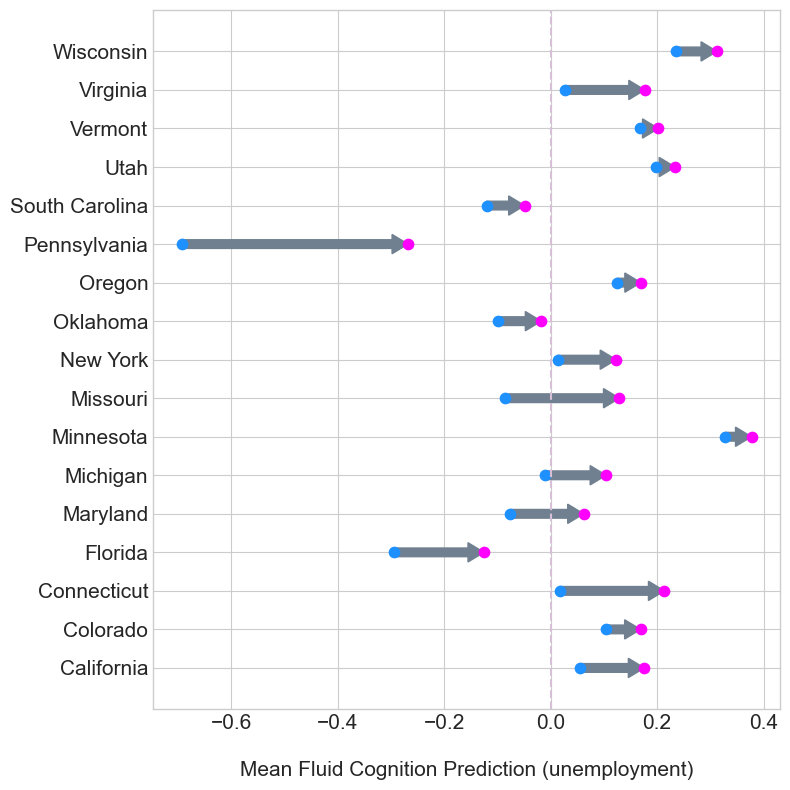

In [57]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Fluid Cognition Prediction (unemployment)',size=15,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Unemployment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_unemp_fluid_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [58]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.2835174031180643,
  -0.5610501593168544,
  -0.08217903730576033,
  0.011493975106607282,
  0.16551067347900253],
 [0.18060119179948847,
  -0.02167729739330182,
  0.05356324613172662,
  -0.09025234036444257,
  0.13010099768952066])

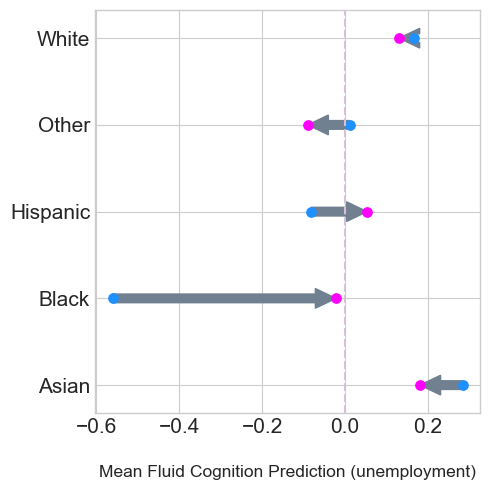

In [59]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Fluid Cognition Prediction (unemployment)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Unemployment Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_unemp_fluid_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_54557/2659431252.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_54557/2659431252.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


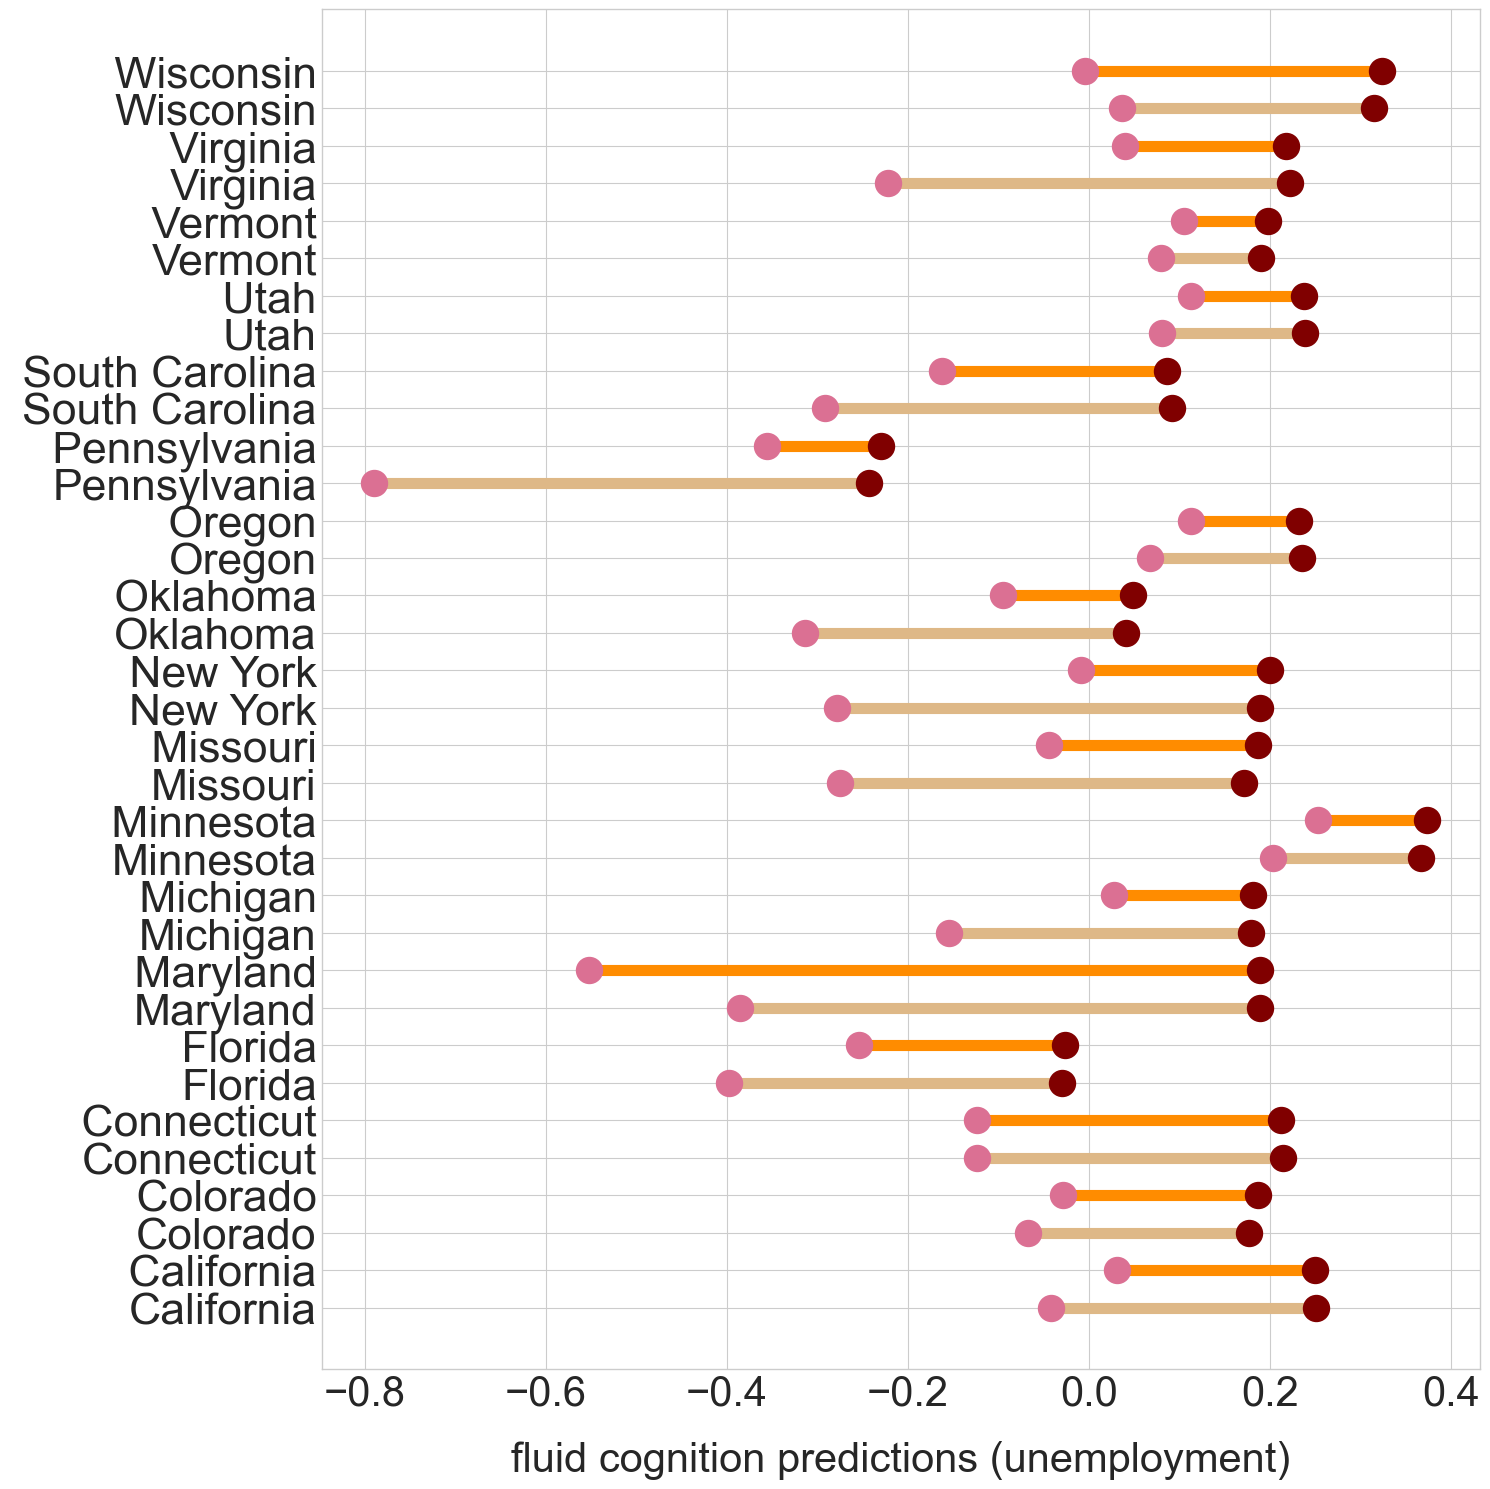

In [60]:
#low_state_edu2,high_state_edu2,low_state_edu,high_state_edu
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='maroon', label='low unemp', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='palevioletred', label='high unemp', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='maroon', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='palevioletred', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('fluid cognition predictions (unemployment)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low unemp', 'high unemp'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_unemp_fluid_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_54557/55789389.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_54557/55789389.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


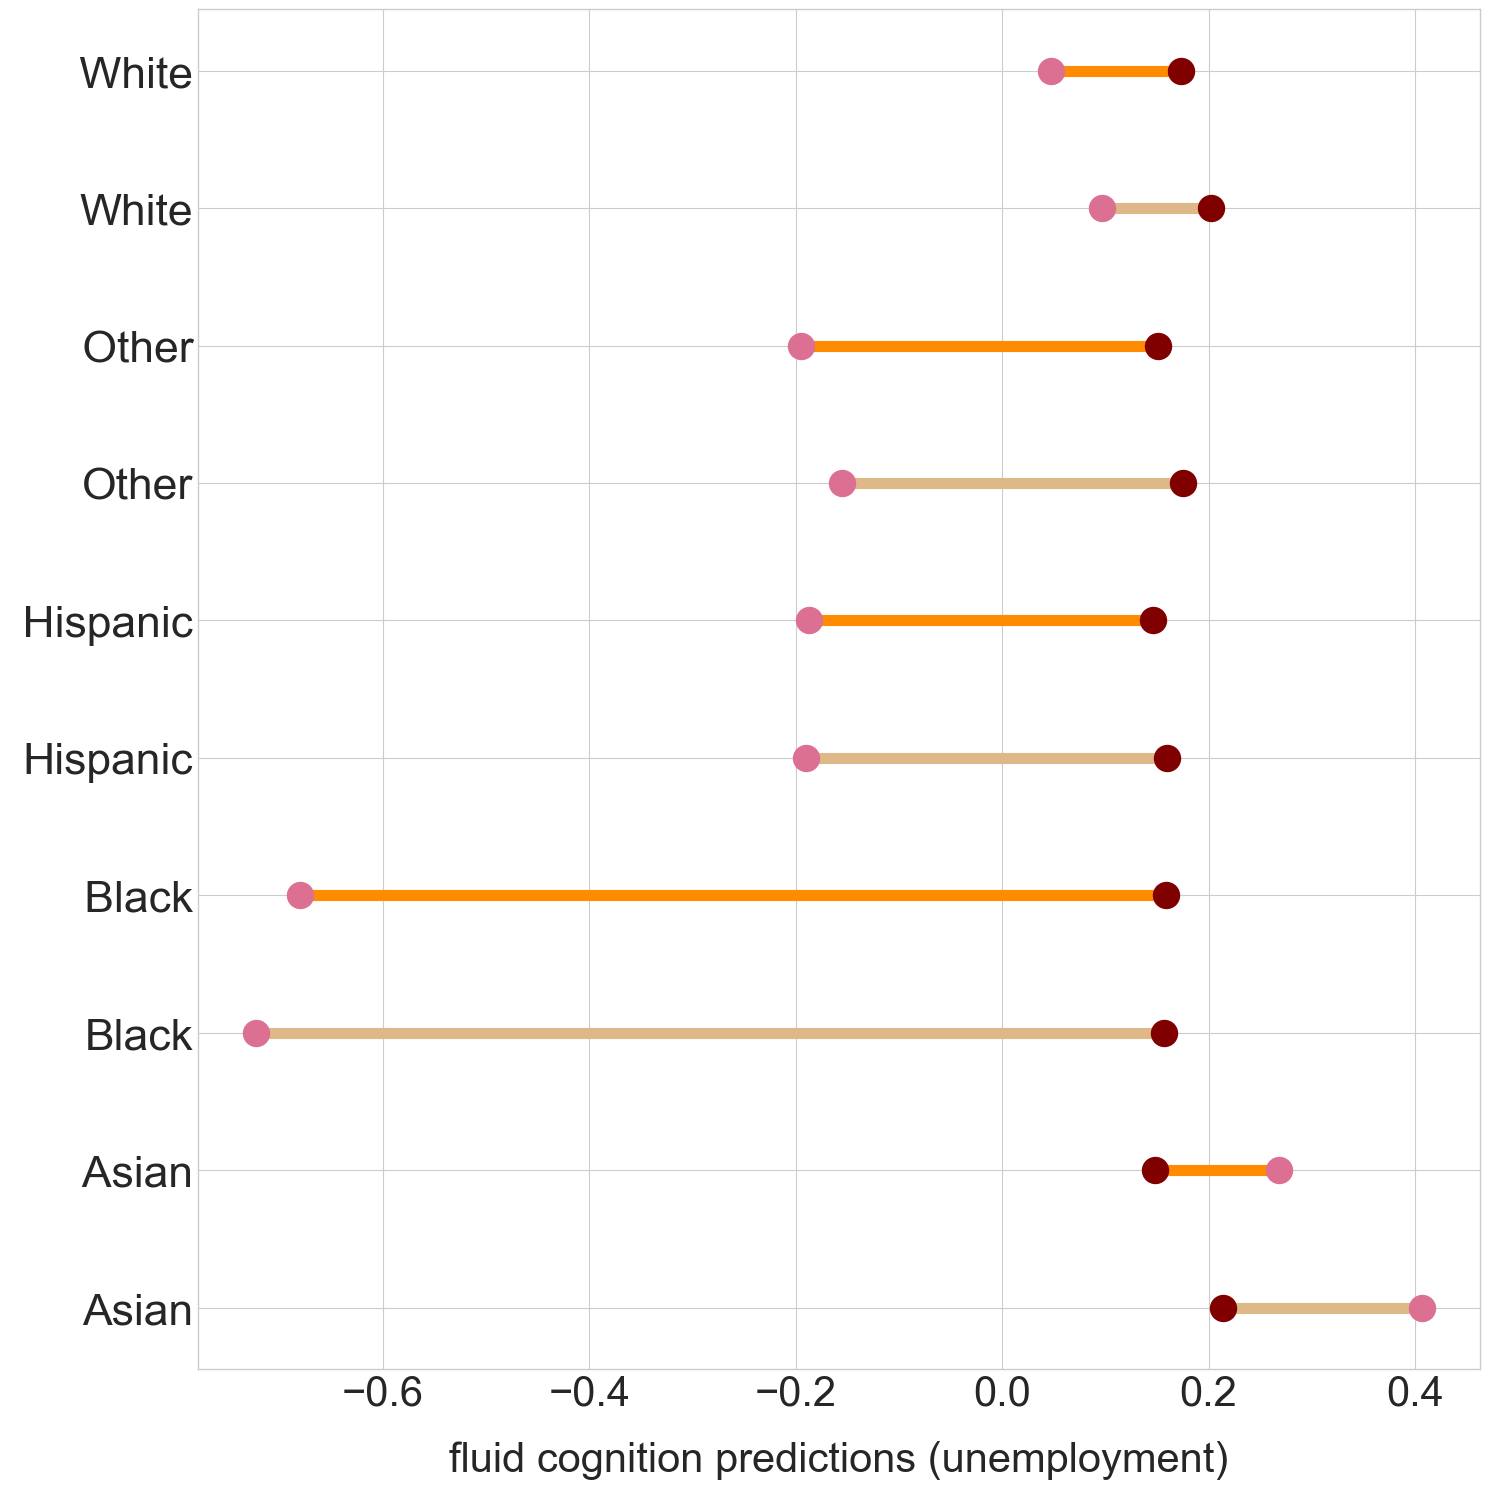

In [61]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='burlywood', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='darkorange', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='maroon', label='low unemp', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='palevioletred', label='high unemp', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='maroon', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='palevioletred', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('fluid cognition predictions (unemployment)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low unemp', 'high unemp'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_unemp_fluid_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()